# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from pandas.api.types import is_numeric_dtype
import time

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", delimiter=";")

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", delimiter=";")

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print("General demographics data")
azdias.shape

General demographics data


(891221, 85)

In [4]:
azdias.head(10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [5]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [6]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [7]:
print("Feature summary file")
feat_info.shape

Feature summary file


(85, 4)

In [8]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,ALTERSKATEGORIE_GROB,person,ordinal,[-1]
freq,1,43,49,26


In [9]:
feat_info.head(85)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [10]:
# Identify missing or unknown data values and convert them to NaNs.

#Find out, which values are missing or are unknown, by getting the unique values from the column.
missing_values_set = set(feat_info["missing_or_unknown"])
print(missing_values_set)

{'[XX]', '[-1,9]', '[-1,0]', '[-1,0,9]', '[-1]', '[-1,XX]', '[-1,X]', '[0]', '[]'}


In [11]:
#Calculate the percentage of NaNs in each column before processing
percentage_nans = (azdias.isnull().mean().round(3)*100).sort_values(ascending=False)
print("{}".format(percentage_nans[:15]))

KK_KUNDENTYP    65.6
KBA05_ANTG4     15.0
KBA05_ANTG3     15.0
KBA05_BAUMAX    15.0
KBA05_GBZ       15.0
KBA05_ANTG2     15.0
KBA05_ANTG1     15.0
MOBI_REGIO      15.0
KKK             13.6
REGIOTYP        13.6
PLZ8_ANTG1      13.1
PLZ8_ANTG2      13.1
PLZ8_ANTG3      13.1
PLZ8_ANTG4      13.1
PLZ8_BAUMAX     13.1
dtype: float64


In [12]:
azdias_NaN = azdias.copy()
for i in range(azdias_NaN.shape[1]):
    missing_and_unknown =feat_info.missing_or_unknown[i]
    column = azdias_NaN.columns[i]
    missing_and_unknown_list = missing_and_unknown[1:len(missing_and_unknown)-1].split(",")
    for element in missing_and_unknown_list:
        if element not in ["XX","X"]:
            if element!="" and int(element) in azdias_NaN[column].value_counts():
                azdias_NaN[column]=azdias_NaN[column].replace(int(element),np.nan)
                print("Element:",element,"Column:",column,"Values after processing:\n",azdias_NaN[column].value_counts())
        else:
            azdias_NaN[column]=azdias_NaN[column].replace(element,np.nan)
            print("Element:",element,"Column:",column,"Values after processing:\n",azdias_NaN[column].value_counts())

Element: -1 Column: AGER_TYP Values after processing:
 2.0    98472
1.0    79802
3.0    27104
0.0     8340
Name: AGER_TYP, dtype: int64
Element: 0 Column: AGER_TYP Values after processing:
 2.0    98472
1.0    79802
3.0    27104
Name: AGER_TYP, dtype: int64
Element: 9 Column: ALTERSKATEGORIE_GROB Values after processing:
 3.0    358533
4.0    228510
2.0    158410
1.0    142887
Name: ALTERSKATEGORIE_GROB, dtype: int64
Element: 0 Column: GEBURTSJAHR Values after processing:
 1967.0    11183
1965.0    11090
1966.0    10933
1970.0    10883
1964.0    10799
1968.0    10792
1963.0    10513
1969.0    10360
1980.0    10275
1962.0    10082
1961.0     9880
1971.0     9786
1982.0     9516
1978.0     9509
1960.0     9492
1979.0     9422
1981.0     9374
1977.0     9296
1959.0     9098
1972.0     9027
1976.0     9005
1983.0     8887
1974.0     8676
1984.0     8553
1975.0     8480
1973.0     8356
1958.0     8323
1986.0     8192
1985.0     8180
1957.0     8099
          ...  
2009.0      559
2008.0    

In [13]:
azdias_NaN.shape == azdias.shape

True

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [14]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
percentage_nans = (azdias_NaN.isnull().mean().round(3)*100).sort_values(ascending=False)
print("Top ten columns with missing values:")
print("{}".format(percentage_nans[:10]))

Top ten columns with missing values:
TITEL_KZ          99.8
AGER_TYP          77.0
KK_KUNDENTYP      65.6
KBA05_BAUMAX      53.5
GEBURTSJAHR       44.0
ALTER_HH          34.8
REGIOTYP          17.7
KKK               17.7
W_KEIT_KIND_HH    16.6
KBA05_ANTG4       15.0
dtype: float64


In [15]:
percentage_nans_dataframe = pd.DataFrame(percentage_nans, columns=["percentage_nans"])
feat_nan = (feat_info
            .merge(percentage_nans_dataframe, left_on='attribute', right_index=True)
           )

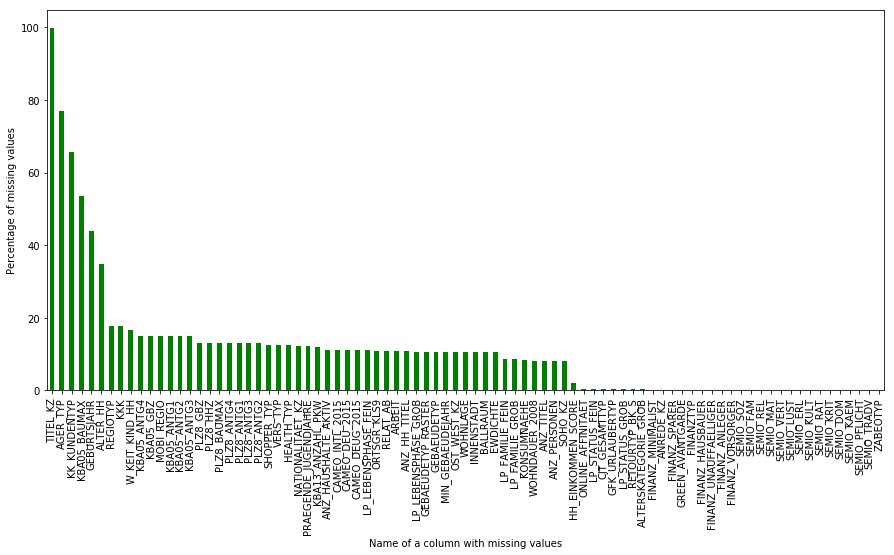

Total columns with missing values: 85 columns


In [16]:
percentage_nans.plot.bar(figsize=(15,7),facecolor="g")
plt.xlabel("Name of a column with missing values")
plt.ylabel("Percentage of missing values")
plt.show()
print("Total columns with missing values: {} columns".format(len(percentage_nans)))

Text(0,0.5,'Quantity')

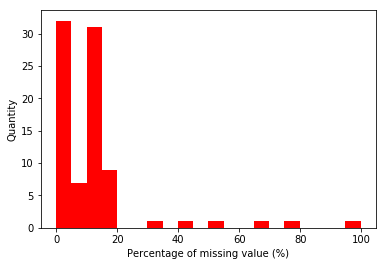

In [17]:
plt.hist(percentage_nans, facecolor="r",bins=20)
plt.xlabel("Percentage of missing value (%)")
plt.ylabel("Quantity")

In [18]:
# Investigate patterns in the amount of missing data in each column.
pd.DataFrame({"Value":percentage_nans}).describe()

,Value
count,85.000000
mean,11.055294
std,16.458082
min,0.000000
25%,0.000000
50%,10.500000
75%,13.100000
max,99.800000


In [19]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
outlier_columns= feat_nan[feat_nan.percentage_nans > 18].attribute
print(outlier_columns)
azdias_drop = azdias_NaN.drop(outlier_columns, axis=1)

0         AGER_TYP
11     GEBURTSJAHR
40        TITEL_KZ
43        ALTER_HH
47    KK_KUNDENTYP
64    KBA05_BAUMAX
Name: attribute, dtype: object


In [20]:
azdias_drop.shape

(891221, 79)

In [21]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [22]:
azdias_drop.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,2.0,2,5.0,1,5,1,5,4,3,4,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,1.0,1,3.0,3,3,4,1,3,2,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,3.0,1,3.0,4,4,2,4,2,2,6,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,3.0,2,4.0,2,4,2,3,5,4,1,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

Most columns have a small amount of missing data. The threshold of missing data in the most cases does not go beyond 18%, which we can see from the graphs above. For example, the column "REGIOTYP" has 17.7% of missing data. 
However, some columns have an extrem amount of missing data (34% or more). Those columns are the outliers in the dataset. Therefore, those columns have to be deleted. 

Deleted columns:
- AGER_TYP
- GEBURTSJAHR
- TITEL_KZ
- KK_KUNDENTYP
- KBA05_BAUMAX

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. Make sure you report your observations in the discussion section. **Either way, you should continue your analysis below using just the subset of the data with few or no missing values.**

In [23]:
# How much data is missing in each row of the dataset?
row_missing = azdias_drop.isnull().sum(axis = 1)
print(row_missing)
row_missing.describe()

0         43
1          0
2          0
3          7
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11        47
12         6
13         8
14        47
15         8
16         6
17        47
18         3
19         0
20        10
21         0
22         0
23         8
24        47
25         5
26        19
27         0
28         0
29         2
          ..
891191     0
891192     0
891193     0
891194     0
891195     0
891196     0
891197     0
891198     0
891199     0
891200     0
891201     0
891202     0
891203    14
891204     0
891205     0
891206     0
891207     0
891208     3
891209     0
891210     0
891211     0
891212     0
891213     0
891214     0
891215     0
891216     3
891217     4
891218     5
891219     0
891220     0
Length: 891221, dtype: int64


count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64

Text(0,0.5,'Quantity')

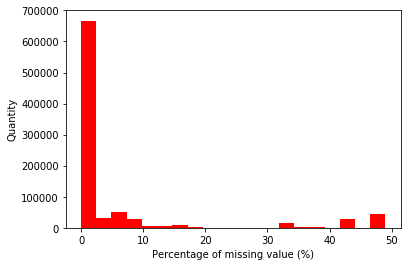

In [24]:
plt.hist(row_missing, facecolor="r",bins=20)
plt.xlabel("Percentage of missing value (%)")
plt.ylabel("Quantity")

In [25]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
few_missing = azdias_drop.loc[row_missing<=20]
many_missing = azdias_drop.loc[row_missing>20]

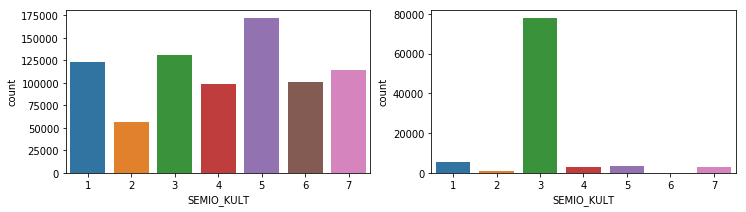

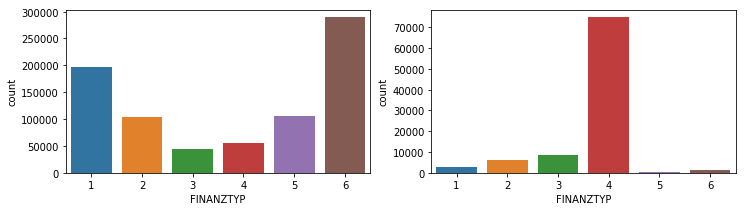

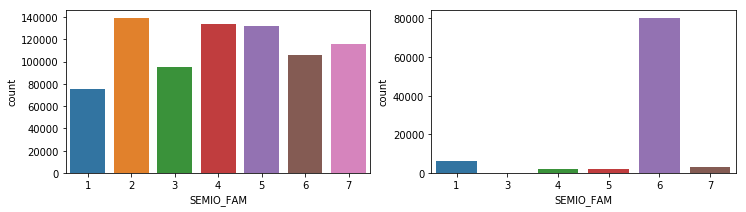

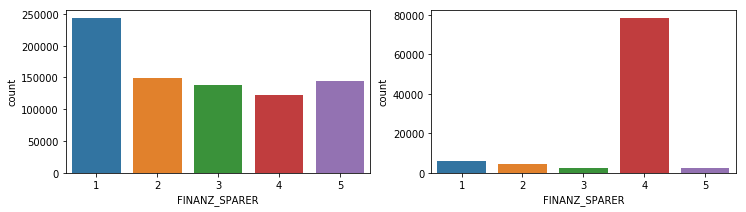

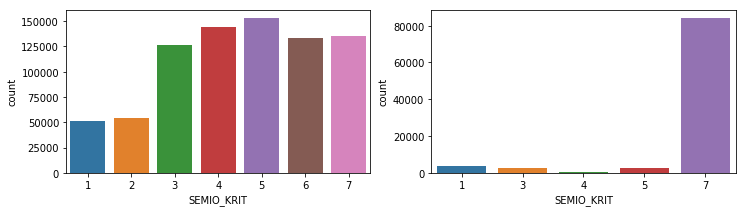

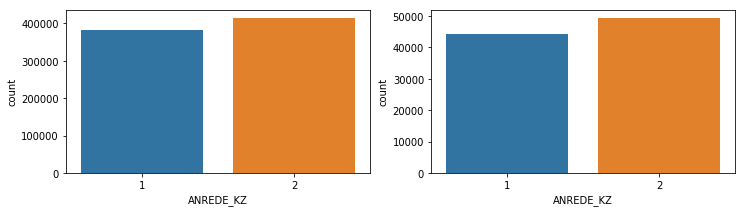

In [26]:
#Create a list of non-missing columns.
compare_columns = list(set(few_missing.dropna(axis=1).columns).intersection(many_missing.dropna(axis=1).columns))
#Compare, if the distributions of non-missing columns look similar between the data with many missing values 
#and the data with few or no missing values.

for i in compare_columns[:6]:
    fig, axis = plt.subplots(1,2,figsize=(12,3))
    axis = axis.ravel()
    sns.countplot(x = few_missing[i], ax=axis[0])
    sns.countplot(x = many_missing[i], ax=axis[1])
    
# Looking on the graphs, compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
#Subset left: few missing
#Subset right: many missing

#### Discussion 1.1.3: Assess Missing Data in Each Row

We observed in the comparision, that the distributions of non-missing features do not look similar between the data with many missing values and the data with few or no missing values.

Therefore we could argue, that simply dropping those points from the analysis will cause a major issue. 

We see, that the data with many missing values looks very different from the data with few or no missing values. 
Because the data with lots of missing values is qualitatively different from data with few or no missing values, we cannot just simply drop the rows. 

I decided to keep the rows to not miss too much data.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

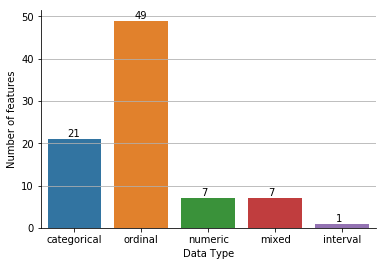

In [27]:
# How many features are there of each data type?
fig, axis = plt.subplots(figsize=(6,4))
plt.grid(True)
sns.countplot(data=feat_info,x="type",ax = axis)
axis.set_ylabel("Number of features")
axis.set_xlabel("Data Type")
for p in axis.patches:
    axis.annotate("{}".format(p.get_height()), (p.get_x()+0.3, p.get_height()+0.5))
    sns.despine(ax = axis)

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [28]:
# Get info about categorical variables
feat_info[feat_info.type == "categorical"].attribute

0             AGER_TYP
2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
40            TITEL_KZ
41            VERS_TYP
42            ZABEOTYP
47        KK_KUNDENTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

In [29]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# Filter feat_info to a new dataframe with dropped columns.
feat_info = feat_info[feat_info.attribute.isin(azdias_drop.columns)]

# First, get info about the number of categoricals of categorical variables
columns = feat_info[feat_info.type == "categorical"].attribute
columns_unique = azdias_drop[columns].nunique()
columns_unique

#extract categorical columns with their data types and number of categories
azdias_drop[columns].dtypes
azdias_drop[columns[-3:]].sample(20)


,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015
764805,O,4,4E
855693,W,8,8D
173743,W,3,3A
669064,O,8,8C
226155,W,4,4A
3862,W,4,4C
39079,W,2,2D
537650,NaN,NaN,NaN
122724,NaN,NaN,NaN
205468,W,8,8B


In [30]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias_cleaned = azdias_drop.copy()
columns_unique = azdias_cleaned[columns].nunique()
print(columns_unique.sort_values())

azdias_cleaned["OST_WEST_KZ"] = azdias_cleaned["OST_WEST_KZ"].replace({"O": 0,"W": 1})
azdias_cleaned[columns[-3:]].sample(20)

ANREDE_KZ            2
OST_WEST_KZ          2
VERS_TYP             2
SOHO_KZ              2
GREEN_AVANTGARDE     2
NATIONALITAET_KZ     3
SHOPPER_TYP          4
LP_STATUS_GROB       5
LP_FAMILIE_GROB      5
FINANZTYP            6
ZABEOTYP             6
CJT_GESAMTTYP        6
GEBAEUDETYP          7
CAMEO_DEUG_2015      9
LP_STATUS_FEIN      10
LP_FAMILIE_FEIN     11
GFK_URLAUBERTYP     12
CAMEO_DEU_2015      44
dtype: int64


,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015
208959,1.0,9,9C
485699,NaN,NaN,NaN
453255,1.0,3,3C
740483,0.0,7,7B
32810,NaN,NaN,NaN
206250,1.0,2,2D
148481,1.0,8,8C
412895,1.0,4,4C
824691,0.0,9,9B
513014,1.0,4,4C


In [31]:
# Choose the multilevel categorical features
columns_unique = azdias_cleaned[columns].nunique()
columns_multilevel = columns_unique[columns_unique >2]
columns_multilevel.sort_values()

NATIONALITAET_KZ     3
SHOPPER_TYP          4
LP_FAMILIE_GROB      5
LP_STATUS_GROB       5
CJT_GESAMTTYP        6
FINANZTYP            6
ZABEOTYP             6
GEBAEUDETYP          7
CAMEO_DEUG_2015      9
LP_STATUS_FEIN      10
LP_FAMILIE_FEIN     11
GFK_URLAUBERTYP     12
CAMEO_DEU_2015      44
dtype: int64

In [32]:
azdias_cleaned = azdias_cleaned.drop(columns_multilevel.index,axis=1)
azdias_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 66 columns):
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null int64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      793589 non-null float64
LP_LEBENSPHASE_GROB      796649 non-null float64
PRAEGENDE_JUGENDJAHRE    783057 non-null float64
RETOURTYP_BK_S           886367 non-null float64
SEMIO_SOZ                891221 non-null int64
SEMIO_FAM                891221 non-null int64
SEMIO_REL                891221 non-null int64
SEMIO_MAT                891221 non-null int64
SEMIO_VERT               891221

#### Discussion 1.2.1: Re-Encode Categorical Features

The dataset contains 5 binary categoricals, and 13 multilevel categoricals.

The 5 binary (two-level) categoricals are:
- ANREDE_KZ   
- OST_WEST_KZ
- VERS_TYP
- SOHO_KZ
- GREEN_AVANTGARDE

OST_WEST_KZ has non-numeric values. We needed to re-encode it, where the values O, and W, were replaced with numerical values.

The 13 multilevel categoricals are:
- NATIONALITAET_KZ 
- SHOPPER_TYP
- LP_FAMILIE_GROB      
- LP_STATUS_GROB       
- CJT_GESAMTTYP        
- FINANZTYP            
- ZABEOTYP             
- GEBAEUDETYP          
- CAMEO_DEUG_2015      
- LP_STATUS_FEIN      
- LP_FAMILIE_FEIN     
- GFK_URLAUBERTYP     
- CAMEO_DEU_2015      

Those categoricals were dropped from the analysis. They contain the information covered by other columns. For example FINANZ_ is covered by FINANZTYP. Therefore we choose to remove them in this step. We want to keep the analysis simple as possible, an do not increase the number of variables, if not neccesary. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [33]:
feat_info[feat_info.type == 'mixed']

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [34]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

## From Dictionary PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)


In [35]:
# Investigate the variable "PRAEGENDE_JUGENDJAHRE"
print(azdias_cleaned.PRAEGENDE_JUGENDJAHRE.sample(5),"\n")
print(azdias_cleaned.PRAEGENDE_JUGENDJAHRE.nunique(),"\n")
print(azdias_cleaned.PRAEGENDE_JUGENDJAHRE.value_counts().sort_index())

536248    14.0
634200     9.0
248445    14.0
251699     8.0
280397     3.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64 

15 

1.0      21282
2.0       7479
3.0      55195
4.0      20451
5.0      86416
6.0      25652
7.0       4010
8.0     145988
9.0      33570
10.0     85808
11.0     35752
12.0     24446
13.0      5764
14.0    188697
15.0     42547
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64


## New Encodings for the variable PRAEGENDE_JUGENDJAHRE:
- PRAEGENDE_JUGENDJAHRE_DECADE: New variable, which describes the decade, a person was living in the youth.

| Decade | Old encodings | New encoding | 
|--------|---------------|--------------|
|  40s   |     1,2       |      1       |
|  50s   |     3,4       |      2       |
|  60s   |    5,6,7      |      3       |
|  70s   |     8,9       |      4       |
|  80s   |  10,11,12,13  |      5       |
|  90s   |    14,15      |      6       |

- PRAEGENDE_JUGENDJAHRE_MOVEMENT: New variable, which describes the movement, a person was involved in the youth

|  Movement  |  Old encodings   | New encoding | 
|------------|------------------|--------------|
| Mainstream |1,3,5,7,8,10,12,14|      1       |
| Avantgarde |2,4,6,7,9,11,13,15|      2       |


In [36]:
new_encoding_decade =  {1: 1, 
                        2: 1,
                        3: 2,
                        4: 2,
                        5: 3,
                        6: 3,
                        7: 3,
                        8: 4,
                        9: 4,
                        10: 5,
                        11: 5, 
                        12: 5, 
                        13: 5,
                        14: 6, 
                        15: 6}
new_encoding_movement= {1: 1, 
                        2: 2,
                        3: 1,
                        4: 2, 
                        5: 1,
                        6: 2,
                        7: 2,
                        8: 1,
                        9: 2,
                        10: 1, 
                        11: 2,
                        12: 1,
                        13: 2,
                        14: 1,
                        15: 2}


azdias_cleaned["PRAEGENDE_JUGENDJAHRE_DECADE"] = azdias_cleaned["PRAEGENDE_JUGENDJAHRE"].replace(new_encoding_decade)
azdias_cleaned["PRAEGENDE_JUGENDJAHRE_MOVEMENT"] = azdias_cleaned["PRAEGENDE_JUGENDJAHRE"].replace(new_encoding_movement)

In [37]:
print(azdias_cleaned.PRAEGENDE_JUGENDJAHRE_DECADE.value_counts())
print(azdias_cleaned.PRAEGENDE_JUGENDJAHRE_MOVEMENT.value_counts())

6.0    231244
4.0    179558
5.0    151770
3.0    116078
2.0     75646
1.0     28761
Name: PRAEGENDE_JUGENDJAHRE_DECADE, dtype: int64
1.0    607832
2.0    175225
Name: PRAEGENDE_JUGENDJAHRE_MOVEMENT, dtype: int64


In [38]:
#Sanity check
print(azdias_cleaned.PRAEGENDE_JUGENDJAHRE.isnull().sum() == azdias_cleaned.PRAEGENDE_JUGENDJAHRE_DECADE.isnull().sum())
print(azdias_cleaned.PRAEGENDE_JUGENDJAHRE.isnull().sum() == azdias_cleaned.PRAEGENDE_JUGENDJAHRE_MOVEMENT.isnull().sum())

True
True


In [39]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

## From Dictionary:  CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [40]:
# Investigate the variable "CAMEO_INTL_2015
print(azdias_cleaned.CAMEO_INTL_2015.sample(5),"\n")
print(azdias_cleaned.CAMEO_INTL_2015.nunique(),"\n")
print(azdias_cleaned.CAMEO_INTL_2015.value_counts())

477305    43
608961    25
665553    14
839951    15
698488    14
Name: CAMEO_INTL_2015, dtype: object 

21 

51    133694
41     92336
24     91158
14     62884
43     56672
54     45391
25     39628
22     33155
23     26750
13     26336
45     26132
55     23955
52     20542
31     19024
34     18524
15     16974
44     14820
12     13249
35     10356
32     10354
33      9935
Name: CAMEO_INTL_2015, dtype: int64


## New Encodings for the variable CAMEO_INTL_2015:
- CAMEO_INTL_2015_WEALTH: New variable, which describes wealth of the household, a person is living in.

|          Wealth          | Old encodings | New encoding | 
|--------------------------|---------------|--------------|
| Wealthy Households       | 11,12,13,14,15|      1       |
| Prosperous Households    | 21,22,23,24,25|      2       |
| Comfortable Households   | 31,32,33,34,35|      3       |
| Less Affluent Households | 41,42,43,44,45|      4       |
| Poorer Households        | 51,52,53,54,55|      5       |

- CAMEO_INTL_2015_LIFE_STAGE: New variable, which describes one's stage of life.

|           Life Stage             | Old encodings | New encoding | 
|----------------------------------|---------------|--------------|
| Pre-Family Couples & Singles     |11,21,31,41,51 |      1       |
| Young Couples With Children      |12,22,32,42,52 |      2       |
| Families With School Age Children|13,23,33,43,53 |      3       |
| Older Families & Mature Couples  |14,24,34,44,54 |      4       |
| Elders In Retirement             |15,25,35,45,55 |      5       |

In [41]:
def wealth_encoding(x):
    if not pd.isnull(x):
        if int(str(x)[0]) ==1:
            return 1
        if int(str(x)[0]) ==2:
            return 2
        if int(str(x)[0]) ==3:
            return 3
        if int(str(x)[0]) ==4:
            return 4
        if int(str(x)[0]) ==5:
            return 5
    
def life_stage_encoding(x):
    if not pd.isnull(x):
        if int(str(x)[1]) ==1:
            return 1
        if int(str(x)[1]) ==2:
            return 2
        if int(str(x)[1]) ==3:
            return 3
        if int(str(x)[1]) ==4:
            return 4
        if int(str(x)[1]) ==5:
            return 5

In [42]:
azdias_cleaned["CAMEO_INTL_2015_WEALTH"] = azdias_cleaned["CAMEO_INTL_2015"].apply(wealth_encoding)

In [43]:
azdias_cleaned["CAMEO_INTL_2015_LIFE_STAGE"] = azdias_cleaned["CAMEO_INTL_2015"].apply(life_stage_encoding)

In [44]:
print(azdias_cleaned.CAMEO_INTL_2015_WEALTH.value_counts())
print(azdias_cleaned.CAMEO_INTL_2015_LIFE_STAGE.value_counts())

5.0    223582
2.0    190691
4.0    189960
1.0    119443
3.0     68193
Name: CAMEO_INTL_2015_WEALTH, dtype: int64
1.0    245054
4.0    232777
3.0    119693
5.0    117045
2.0     77300
Name: CAMEO_INTL_2015_LIFE_STAGE, dtype: int64


In [45]:
#Sanity check
print(azdias_cleaned.CAMEO_INTL_2015.isnull().sum() == azdias_cleaned.CAMEO_INTL_2015_WEALTH.isnull().sum())
print(azdias_cleaned.CAMEO_INTL_2015.isnull().sum() == azdias_cleaned.CAMEO_INTL_2015_LIFE_STAGE.isnull().sum())

True
True


In [46]:
columns_mixed = feat_info[feat_info.type == 'mixed'].attribute
columns_mixed = azdias_cleaned[columns_mixed].nunique()

In [47]:
print(columns_mixed)

LP_LEBENSPHASE_FEIN      40
LP_LEBENSPHASE_GROB      12
PRAEGENDE_JUGENDJAHRE    15
WOHNLAGE                  8
CAMEO_INTL_2015          21
PLZ8_BAUMAX               5
dtype: int64


In [48]:
azdias_cleaned = azdias_cleaned.drop(columns_mixed.index,axis=1)
azdias_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 64 columns):
ALTERSKATEGORIE_GROB              888340 non-null float64
ANREDE_KZ                         891221 non-null int64
FINANZ_MINIMALIST                 891221 non-null int64
FINANZ_SPARER                     891221 non-null int64
FINANZ_VORSORGER                  891221 non-null int64
FINANZ_ANLEGER                    891221 non-null int64
FINANZ_UNAUFFAELLIGER             891221 non-null int64
FINANZ_HAUSBAUER                  891221 non-null int64
GREEN_AVANTGARDE                  891221 non-null int64
HEALTH_TYP                        780025 non-null float64
RETOURTYP_BK_S                    886367 non-null float64
SEMIO_SOZ                         891221 non-null int64
SEMIO_FAM                         891221 non-null int64
SEMIO_REL                         891221 non-null int64
SEMIO_MAT                         891221 non-null int64
SEMIO_VERT                        891221 no

In [49]:
azdias_cleaned.shape

(891221, 64)

#### Discussion 1.2.2: Engineer Mixed-Type Features


The two mixed features PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 required special treatment.
- PRAEGENDE_JUGENDJAHRE have been engineered to PRAEGENDE_JUGENDJAHRE_DECADE, and PRAEGENDE_JUGENDJAHRE_MOVEMENT. PRAEGENDE_JUGENDJAHRE itself was dropped from the dataframe.
- CAMEO_INTL_2015 have been engineered to CAMEO_INTL_2015_WEALTH and CAMEO_INTL_2015_LIFE_STAGE. CAMEO_INTL_2015 itself was dropped from the dataframe.

- Other mixed features LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB, WOHNLAGE, PLZ8_BAUMAX are covered by other features, so it was safe to remove them from the dataframe. This is what we did.
- The final number of column after the enginnering procedure is 64.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [50]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

In [51]:
#The orginal columns are excluded and replaced with the engineered columns.
#Columns list 
azdias_cleaned.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
       'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
       'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT',
       'SEMIO_TRADV', 'SOHO_KZ', 'VERS_TYP', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'KBA05_ANTG1', 'KBA05_ANTG2',
       'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE',
       'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO',
       'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1',
       'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ',
       'ARBEI

In [52]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

#calculate the number of numeric columns
numeric_columns = sum([is_numeric_dtype(azdias_cleaned[column]) for column in azdias_cleaned.columns])

#the number of numeric columns should match the general number of columns
if (numeric_columns == azdias_cleaned.shape[1]):
    print("Dataframe is ready.")


Dataframe is ready.


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [53]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", delimiter=";")
    for i in range(df.shape[1]):
        missing_and_unknown =feat_info.missing_or_unknown[i]
        column = df.columns[i]
        missing_and_unknown_list = missing_and_unknown[1:len(missing_and_unknown)-1].split(",")
        for element in missing_and_unknown_list:
            if element not in ["XX","X"]:
                if element!="" and int(element) in df[column].value_counts():
                    df[column]=df[column].replace(int(element),np.nan)
                    print("Element:",element,"Column:",column,"Values after processing:\n",df[column].value_counts())
            else:
                df[column]=df[column].replace(element,np.nan)
                print("Element:",element,"Column:",column,"Values after processing:\n",df[column].value_counts())

    # remove selected columns and rows, ...
    percentage_nans = (df.isnull().mean().round(3)*100).sort_values(ascending=False)
    percentage_nans_dataframe = pd.DataFrame(percentage_nans, columns=["percentage_nans"])
    feat_nan = (feat_info.merge(percentage_nans_dataframe, left_on='attribute', right_index=True))
    outlier_columns = ["AGER_TYP","GEBURTSJAHR","TITEL_KZ","ALTER_HH","KK_KUNDENTYP","KBA05_BAUMAX"]
    df = df.drop(outlier_columns, axis=1)  
    # select, re-encode, and engineer column values.
    feat_info = feat_info[feat_info.attribute.isin(df.columns)]
    columns = feat_info[feat_info.type == "categorical"].attribute
    columns_unique = df[columns].nunique()
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace({"O": 0,"W": 1})
    #df.OST_WEST_KZ= df.OST_WEST_KZ.replace({'O': 0,'W': 1})
    columns_unique = df[columns].nunique()
    columns_multilevel = columns_unique[columns_unique >2]
    df = df.drop(columns_multilevel.index,axis=1)
    new_encoding_decade =  {1: 1, 
                        2: 1,
                        3: 2,
                        4: 2,
                        5: 3,
                        6: 3,
                        7: 3,
                        8: 4,
                        9: 4,
                        10: 5,
                        11: 5, 
                        12: 5, 
                        13: 5,
                        14: 6, 
                        15: 6}
    new_encoding_movement= {1: 1, 
                        2: 2,
                        3: 1,
                        4: 2, 
                        5: 1,
                        6: 2,
                        7: 2,
                        8: 1,
                        9: 2,
                        10: 1, 
                        11: 2,
                        12: 1,
                        13: 2,
                        14: 1,
                        15: 2}


    df["PRAEGENDE_JUGENDJAHRE_DECADE"] = df["PRAEGENDE_JUGENDJAHRE"].replace(new_encoding_decade)
    df["PRAEGENDE_JUGENDJAHRE_MOVEMENT"] = df["PRAEGENDE_JUGENDJAHRE"].replace(new_encoding_movement)

    df["CAMEO_INTL_2015_WEALTH"] = df["CAMEO_INTL_2015"].apply(wealth_encoding)            
    df["CAMEO_INTL_2015_LIFE_STAGE"] = df["CAMEO_INTL_2015"].apply(life_stage_encoding)

    columns_mixed = feat_info[feat_info.type == 'mixed'].attribute
    columns_mixed = df[columns_mixed].nunique()
    df = df.drop(columns_mixed.index,axis=1)

    # Return the cleaned dataframe.
    return df

In [54]:
azdias_cleaned = clean_data(azdias)

Element: -1 Column: AGER_TYP Values after processing:
 2.0    98472
1.0    79802
3.0    27104
0.0     8340
Name: AGER_TYP, dtype: int64
Element: 0 Column: AGER_TYP Values after processing:
 2.0    98472
1.0    79802
3.0    27104
Name: AGER_TYP, dtype: int64
Element: 9 Column: ALTERSKATEGORIE_GROB Values after processing:
 3.0    358533
4.0    228510
2.0    158410
1.0    142887
Name: ALTERSKATEGORIE_GROB, dtype: int64
Element: 0 Column: GEBURTSJAHR Values after processing:
 1967.0    11183
1965.0    11090
1966.0    10933
1970.0    10883
1964.0    10799
1968.0    10792
1963.0    10513
1969.0    10360
1980.0    10275
1962.0    10082
1961.0     9880
1971.0     9786
1982.0     9516
1978.0     9509
1960.0     9492
1979.0     9422
1981.0     9374
1977.0     9296
1959.0     9098
1972.0     9027
1976.0     9005
1983.0     8887
1974.0     8676
1984.0     8553
1975.0     8480
1973.0     8356
1958.0     8323
1986.0     8192
1985.0     8180
1957.0     8099
          ...  
2009.0      559
2008.0    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values before applying your scaler. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [55]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

In [56]:
#checking missing values in the columns before applying Imputer
percentage_nans_column = (azdias_cleaned.isnull().mean().round(3)*100).sort_values(ascending=False)
percentage_nans_column

KKK                               17.7
REGIOTYP                          17.7
W_KEIT_KIND_HH                    16.6
KBA05_ANTG4                       15.0
KBA05_GBZ                         15.0
KBA05_ANTG3                       15.0
KBA05_ANTG2                       15.0
KBA05_ANTG1                       15.0
MOBI_REGIO                        15.0
PLZ8_ANTG1                        13.1
PLZ8_ANTG2                        13.1
PLZ8_ANTG3                        13.1
PLZ8_ANTG4                        13.1
PLZ8_HHZ                          13.1
PLZ8_GBZ                          13.1
HEALTH_TYP                        12.5
VERS_TYP                          12.5
PRAEGENDE_JUGENDJAHRE_DECADE      12.1
PRAEGENDE_JUGENDJAHRE_MOVEMENT    12.1
KBA13_ANZAHL_PKW                  11.9
ANZ_HAUSHALTE_AKTIV               11.2
CAMEO_INTL_2015_WEALTH            11.1
CAMEO_INTL_2015_LIFE_STAGE        11.1
ANZ_HH_TITEL                      10.9
ARBEIT                            10.9
ORTSGR_KLS9              

In [57]:
#checking missing values in the rows before applying Imputer
percentage_nans_row = (azdias_cleaned.isnull().mean(axis=1).round(3)*100).sort_values(ascending=False)
percentage_nans_row

0         59.4
677834    59.4
677664    59.4
677665    59.4
677666    59.4
677668    59.4
677669    59.4
677680    59.4
677682    59.4
148489    59.4
677829    59.4
677830    59.4
677831    59.4
677832    59.4
677833    59.4
677835    59.4
677660    59.4
677836    59.4
677837    59.4
677838    59.4
677839    59.4
677840    59.4
677841    59.4
677842    59.4
677843    59.4
677844    59.4
677845    59.4
677846    59.4
677847    59.4
677848    59.4
          ... 
540246     0.0
540244     0.0
540243     0.0
540242     0.0
540241     0.0
540240     0.0
540239     0.0
540269     0.0
540271     0.0
540300     0.0
540289     0.0
540299     0.0
540298     0.0
540296     0.0
540295     0.0
540293     0.0
540292     0.0
540291     0.0
540290     0.0
540287     0.0
540273     0.0
540286     0.0
540284     0.0
540283     0.0
540281     0.0
540280     0.0
540277     0.0
540275     0.0
540274     0.0
445610     0.0
Length: 891221, dtype: float64

In [58]:
#Applying the Imputer to replace all missing values
imputer = Imputer(missing_values=np.nan, strategy='mean', axis=0)
X = imputer.fit_transform(azdias_cleaned)
azdias_imputed = pd.DataFrame(X, columns=azdias_cleaned.columns)

In [59]:
percentage_nans_column = (azdias_imputed.isnull().mean().round(3)*100).sort_values(ascending=False)
percentage_nans_column

CAMEO_INTL_2015_LIFE_STAGE        0.0
CAMEO_INTL_2015_WEALTH            0.0
HH_EINKOMMEN_SCORE                0.0
ANZ_TITEL                         0.0
ANZ_PERSONEN                      0.0
VERS_TYP                          0.0
SOHO_KZ                           0.0
SEMIO_TRADV                       0.0
SEMIO_PFLICHT                     0.0
SEMIO_KAEM                        0.0
SEMIO_DOM                         0.0
SEMIO_KRIT                        0.0
SEMIO_RAT                         0.0
SEMIO_KULT                        0.0
SEMIO_ERL                         0.0
SEMIO_LUST                        0.0
SEMIO_VERT                        0.0
SEMIO_MAT                         0.0
SEMIO_REL                         0.0
SEMIO_FAM                         0.0
SEMIO_SOZ                         0.0
RETOURTYP_BK_S                    0.0
HEALTH_TYP                        0.0
GREEN_AVANTGARDE                  0.0
FINANZ_HAUSBAUER                  0.0
FINANZ_UNAUFFAELLIGER             0.0
FINANZ_ANLEG

In [60]:
percentage_nans_row = (azdias_imputed.isnull().mean(axis=1).round(3)*100).sort_values(ascending=False)

percentage_nans_row

891220    0.0
297067    0.0
297078    0.0
297077    0.0
297076    0.0
297075    0.0
297074    0.0
297073    0.0
297072    0.0
297071    0.0
297070    0.0
297069    0.0
297068    0.0
297066    0.0
297107    0.0
297065    0.0
297064    0.0
297063    0.0
297062    0.0
297061    0.0
297060    0.0
297059    0.0
297058    0.0
297057    0.0
297056    0.0
297055    0.0
297079    0.0
297080    0.0
297081    0.0
297082    0.0
         ... 
594115    0.0
594114    0.0
594137    0.0
594139    0.0
594164    0.0
594140    0.0
594163    0.0
594162    0.0
594161    0.0
594160    0.0
594159    0.0
594158    0.0
594157    0.0
594156    0.0
594155    0.0
594154    0.0
594153    0.0
594152    0.0
594151    0.0
594150    0.0
594149    0.0
594148    0.0
594147    0.0
594146    0.0
594145    0.0
594144    0.0
594143    0.0
594142    0.0
594141    0.0
0         0.0
Length: 891221, dtype: float64

In [61]:
# Apply feature scaling to the general population demographics data.

In [62]:
#Normalizing all features before applying machine learning techniques.
#We use the StandardScaler to scale each feature to mean 0 and standard deviation 1.
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [63]:
azdias_scaled = pd.DataFrame(X, columns=azdias_cleaned.columns)

In [64]:
azdias_scaled.shape

(891221, 64)

### Discussion 2.1: Apply Feature Scaling

Before applying the dimensionality reduction (PCA), we performed the feature scaling. To do this, we had two main scenarios: 1) removing all data points with missing data 2) applying an Imputer to replace all missing values.

We decided to apply the Imputer, since dropping the data points, would drop a significant amount of data from the analysis. The Imputer replaces missing values with the mean of each column. 
After the Imputer was applied, we scaled the dataframe with the StandardScaler. It was done scaling each feature to mean 0 and standard deviation 1.


### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

64


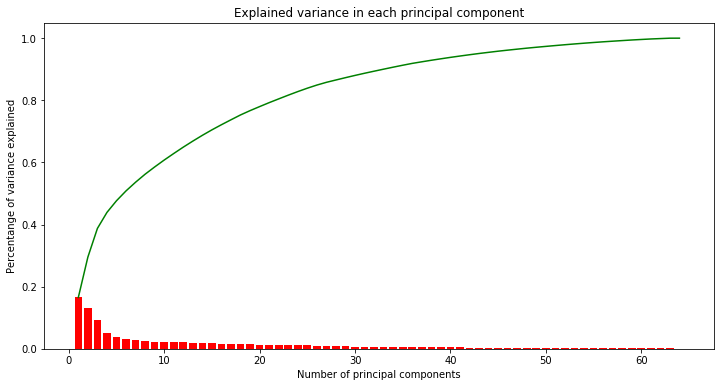

In [65]:
# Apply PCA to the data.
# Investigate the variance accounted for by each principal component.

def screen_plot(pca,df):
    # Apply PCS to the dataframe
    df_pca = pca.fit_transform(df)
    
    # Calculate the variance explained by each dimension
    number_components = len(pca.explained_variance_ratio_)
    print(number_components)
    variance = pca.explained_variance_ratio_
    index = np.arange(1, number_components + 1)
    #Return the cumulative sum of the elements along a given axis.
    cumvariance = np.cumsum(variance)
    
    #Plot graph
    plt.figure(figsize=(12, 6))
    ax = plt.subplot(111)
    ax.plot(index, cumvariance, color="g")
    ax.bar(index, variance, color="r")
    ax.set_xlabel("Number of principal components")
    ax.set_ylabel("Percentange of variance explained")
    plt.title("Explained variance in each principal component")
    
# Call the PCA function
pca = PCA(n_components=None).fit(X)
screen_plot(pca,X)

25


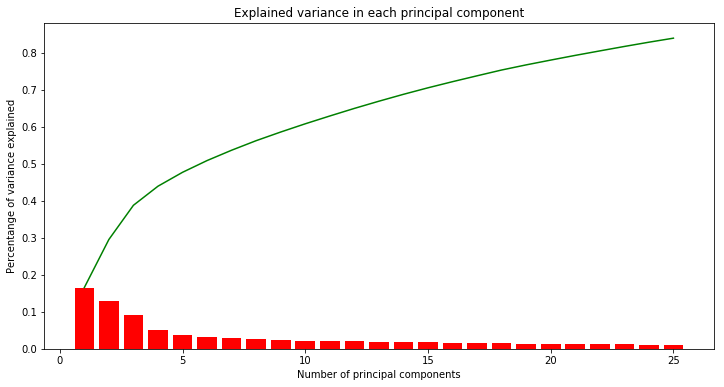

In [66]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca_25 = PCA(n_components=25)
screen_plot(pca_25,X)


22


0.80442618726909931

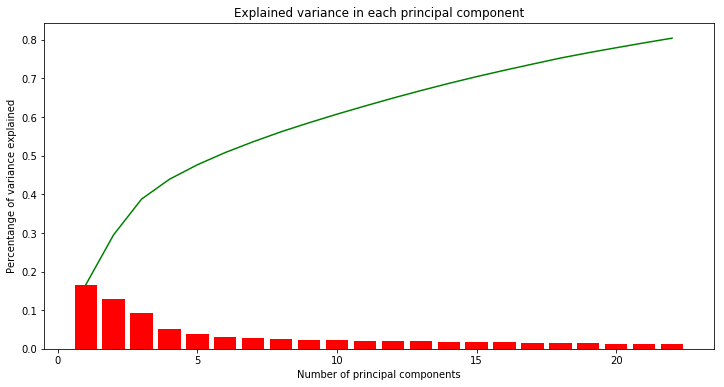

In [67]:
pca_22 = PCA(n_components=22)
screen_plot(pca_22,X)
np.cumsum(pca_22.explained_variance_ratio_[:22])[-1]

In [68]:
#Final PCA
pca = PCA()
X_pca = pca.fit_transform(X)

pca = PCA(n_components=22).fit(X)
X_pca = pca.fit_transform(X)

### Discussion 2.2: Perform Dimensionality Reduction

The cumulative explained variance of the first 22 components is 80.45%, which shows a very stable variance. It means, that 80 % of information can be attributed to each of the 22 principal components, which is a good number.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [102]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def map_weights(pca, df, no_components):
    weights = pd.DataFrame(np.round(pca.components_, 3), columns=df.keys())
    component = weights.iloc[no_components - 1, :]
    comp_pos = component[component > 0].sort_values(ascending=False)
    comp_neg = component[component < 0].sort_values(ascending=True)
    print(comp_pos.head(5), "\n", comp_neg.head(5))

map_weights(pca, azdias_cleaned, 1)

PLZ8_ANTG3                0.233
PLZ8_ANTG4                0.226
CAMEO_INTL_2015_WEALTH    0.211
ORTSGR_KLS9               0.204
EWDICHTE                  0.202
Name: 0, dtype: float64 
 MOBI_REGIO          -0.247
PLZ8_ANTG1          -0.232
KBA05_ANTG1         -0.230
KBA05_GBZ           -0.222
FINANZ_MINIMALIST   -0.215
Name: 0, dtype: float64


In [103]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

map_weights(pca, azdias_cleaned, 2)

ALTERSKATEGORIE_GROB    0.271
FINANZ_VORSORGER        0.251
SEMIO_ERL               0.225
SEMIO_LUST              0.186
RETOURTYP_BK_S          0.173
Name: 1, dtype: float64 
 PRAEGENDE_JUGENDJAHRE_DECADE   -0.264
FINANZ_SPARER                  -0.257
SEMIO_REL                      -0.253
SEMIO_PFLICHT                  -0.244
FINANZ_UNAUFFAELLIGER          -0.239
Name: 1, dtype: float64


In [104]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

map_weights(pca, azdias_cleaned, 3)

SEMIO_VERT           0.354
SEMIO_SOZ            0.291
SEMIO_KULT           0.283
SEMIO_FAM            0.238
FINANZ_MINIMALIST    0.135
Name: 2, dtype: float64 
 ANREDE_KZ    -0.363
SEMIO_KAEM   -0.360
SEMIO_DOM    -0.333
SEMIO_KRIT   -0.308
SEMIO_ERL    -0.183
Name: 2, dtype: float64


### Discussion 2.3: Interpret Principal Components


#### Principal Component 1
- In the 1st principal component the three most positive weight are PLZ8_ANTG3, PLZ8_ANTG4, CAMEO_INTL_2015_WEALTH, the most negative are MOBI_REGIO,PLZ8_ANTG1,KBA05_ANTG1.


#### The interpretation: the first component shows people who live in high-populated cities, with high share of multi-family houses, and high share of poor housholds. They tend to move often and tend to live in the single households. 

#### Principal Component 2
- In the 2nd principal component the three most positive weight are ALTERSKATEGORIE_GROB,FINANZ_VORSORGER,SEMIO_ERL the most negative are  PRAEGENDE_JUGENDJAHRE_DECADE,FINANZ_SPARER,SEMIO_REL.

#### The interpretation: The 2nd component describes, when people are older and have lower financial preperation, and lower event-oriented personality are most likely belonging to the older generation, and has a higher money saving tendency, and higher religious affinity. The component also shows, that younger people, has a lower money saving tendency, and lower religious affinity. 

#### Principal Component 3
- In the 3rd principal component the three most positive weight are SEMIO_VERT,SEMIO_SOZ,SEMIO_KULT the most negative are ANREDE_KZ,SEMIO_KAEM, SEMIO_DOM.

#### The interpretation: The 3rd component describes, that men tend to have less dreamful, less socially-minded, less cultural-minded personality. The component shows that women tend to be more dreamful, more socially-minded, more cultural-minded.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [94]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.

start = time.time()

#Caution: the routine takes a long time to run
error = {}
for k in range(1,20,2):
    print(k)
    error[k] = np.abs(KMeans(n_clusters=k, n_jobs=-1).fit(X_pca).score(X_pca))

time_elapsed = time.time() - start
print("\nTotal running time of the KMeans algorithm: {:.0f}m {:.0f}s".format(time_elapsed//60, time_elapsed % 60))

1
3
5
7
9
11
13
15
17
19

Total running time of the KMeans algorithm: 25m 13s


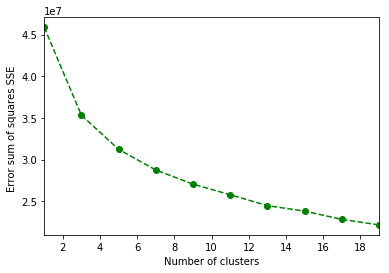

In [95]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
fig, ax = plt.subplots()    
ax = pd.Series(error).plot(linestyle="--", marker="o", color="g")
ax.set_xlabel("Number of clusters")
ax.set_ylabel("Error sum of squares SSE ");

In [74]:
#selected number of clusters

K=11

In [75]:
#Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
#n_jons:-1 using all processors

kmeans_model = KMeans(n_clusters=K, n_jobs=-1,random_state=0).fit(X_pca)
general_population_predict= kmeans_model.fit_predict(X_pca)

In [76]:
#check the shape of the clusters centers
kmeans_model.cluster_centers_.shape

(11, 22)

In [77]:
#check the shape of an array of the cluster assignment
kmeans_model.labels_.shape

(891221,)

### Discussion 3.1: Apply Clustering to General Population

Using the "elbow method", k=11 clusters seems to be a good number to apply the customer data. The idea of the elbow method is to choose the k at which the SSE decreases abruptly. This produces an "elbow effect" in the graph, as we can see above.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [78]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", delimiter=';')

In [79]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

In [80]:
#Clean customer data
customers_cleaned= clean_data(customers)

Element: -1 Column: AGER_TYP Values after processing:
 2.0    45874
1.0    40382
3.0     8658
0.0     4631
Name: AGER_TYP, dtype: int64
Element: 0 Column: AGER_TYP Values after processing:
 2.0    45874
1.0    40382
3.0     8658
Name: AGER_TYP, dtype: int64
Element: 9 Column: ALTERSKATEGORIE_GROB Values after processing:
 4.0    85834
3.0    58364
1.0    28387
2.0    18827
Name: ALTERSKATEGORIE_GROB, dtype: int64
Element: 0 Column: GEBURTSJAHR Values after processing:
 1941.0    3535
1940.0    3085
1939.0    3071
1943.0    2875
1942.0    2802
1938.0    2775
1944.0    2625
1937.0    2603
1936.0    2443
1949.0    2352
1948.0    2266
1950.0    2230
1935.0    2220
1946.0    2165
1954.0    2132
1947.0    2130
1951.0    2116
1952.0    2091
1953.0    2041
1959.0    1962
1955.0    1954
1934.0    1932
1956.0    1904
1962.0    1892
1957.0    1865
1961.0    1851
1960.0    1848
1945.0    1824
1958.0    1796
1963.0    1747
          ... 
1918.0      42
2013.0      39
1998.0      33
1917.0      27
1

In [81]:
customers_cleaned.shape

(191652, 64)

In [82]:
#Apply the Imputer to replace all missing values
customers_imputed = imputer.transform(customers_cleaned)
customers_imputed.shape

(191652, 64)

In [83]:
#Normalizing all features before applying machine learning techniques.
#We use the StandardScaler to scale each feature to mean 0 and standard deviation 1.
customers_scaled = scaler.transform(customers_imputed)
customers_scaled.shape

(191652, 64)

In [84]:
#Apply PCA dimension reduction
customers_pca = pca.transform(customers_scaled)
customers_pca.shape

(191652, 22)

In [85]:
#Apply clustering algorithm
customers_predict = kmeans_model.predict(customers_pca)
customers_predict.shape

(191652,)

In [86]:
np.unique(customers_predict)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int32)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

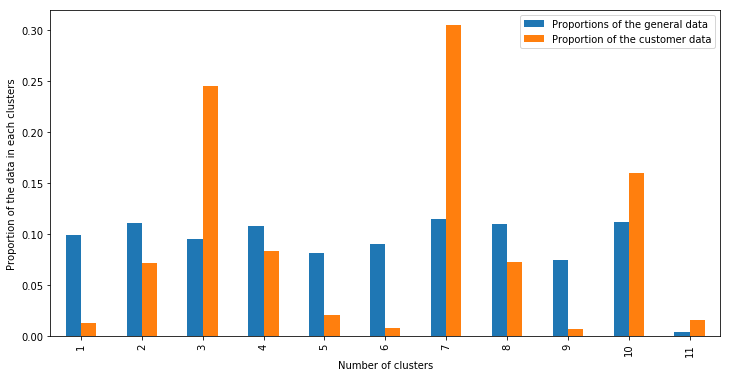

In [96]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

array_general_data= []
array_customer_data = []
x = [index + 1 for index in range(K)]
for index in range(K):
    array_general_data.append((general_population_predict == index).sum()/len(general_population_predict))
    array_customer_data.append((customers_predict == index).sum()/len(customers_predict))

show_data = pd.DataFrame({"Number of clusters" : x, "Proportions of the general data" : array_general_data, "Proportion of the customer data":array_customer_data})
show_data.plot(x="Number of clusters", y = ["Proportions of the general data", "Proportion of the customer data"], kind="bar", figsize=(12,6))

plt.ylabel("Proportion of the data in each clusters")
plt.show()

#### Which cluster or clusters are overrepresented in the customer dataset compared to the general population?
Cluster 7 is the most overrepresented in the customer data compared to the gerneral population. The 2nd most overrepresented cluster is  cluster 3.

#### Which cluster or clusters are underrepresented in the customer dataset compared to the general population?
Cluster 9 is the most underrepresented cluster. The 2nd most underrepresented cluster is  cluster 6.

In [105]:
def cluster_weights(pca, kmeans, df, cluster_no, nrows = 1):
    dataframe = pd.Series(kmeans.cluster_centers_[cluster_no]).sort_values(ascending=False).head(nrows).index.tolist()
    for index in dataframe:
        map_weights(pca, df, index)

In [110]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
cluster_weights(pca, kmeans_model, azdias_cleaned, 7)

PLZ8_ANTG3                0.233
PLZ8_ANTG4                0.226
CAMEO_INTL_2015_WEALTH    0.211
ORTSGR_KLS9               0.204
EWDICHTE                  0.202
Name: 0, dtype: float64 
 MOBI_REGIO          -0.247
PLZ8_ANTG1          -0.232
KBA05_ANTG1         -0.230
KBA05_GBZ           -0.222
FINANZ_MINIMALIST   -0.215
Name: 0, dtype: float64


In [107]:
cluster_weights(pca, kmeans_model, azdias_cleaned, 3)

ALTERSKATEGORIE_GROB    0.271
FINANZ_VORSORGER        0.251
SEMIO_ERL               0.225
SEMIO_LUST              0.186
RETOURTYP_BK_S          0.173
Name: 1, dtype: float64 
 PRAEGENDE_JUGENDJAHRE_DECADE   -0.264
FINANZ_SPARER                  -0.257
SEMIO_REL                      -0.253
SEMIO_PFLICHT                  -0.244
FINANZ_UNAUFFAELLIGER          -0.239
Name: 1, dtype: float64


In [112]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
cluster_weights(pca, kmeans_model, azdias_cleaned, 9)

ALTERSKATEGORIE_GROB    0.271
FINANZ_VORSORGER        0.251
SEMIO_ERL               0.225
SEMIO_LUST              0.186
RETOURTYP_BK_S          0.173
Name: 1, dtype: float64 
 PRAEGENDE_JUGENDJAHRE_DECADE   -0.264
FINANZ_SPARER                  -0.257
SEMIO_REL                      -0.253
SEMIO_PFLICHT                  -0.244
FINANZ_UNAUFFAELLIGER          -0.239
Name: 1, dtype: float64


In [113]:
cluster_weights(pca, kmeans_model, azdias_cleaned, 6)

SEMIO_VERT           0.354
SEMIO_SOZ            0.291
SEMIO_KULT           0.283
SEMIO_FAM            0.238
FINANZ_MINIMALIST    0.135
Name: 2, dtype: float64 
 ANREDE_KZ    -0.363
SEMIO_KAEM   -0.360
SEMIO_DOM    -0.333
SEMIO_KRIT   -0.308
SEMIO_ERL    -0.183
Name: 2, dtype: float64


### Discussion 3.3: Compare Customer Data to Demographics Data

The cluster, which is relatively popular with the mail-order company is the cluster 7, which also dominates the customer data. The cluster typifies people, who live in big cities in poorer housholds, with lower income. They most likely do not live in the single household, tend to move often, and have a higher financial interest.


The cluster, which is relatively unpopular with the mail-order company is the cluster 9. The cluster typifies people, who are older, have a event-oriented, sensual-minded personality, and are determined Minimal-Returner. They are most like money-saver, have a highest affinity religion and are dutiful


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.